In [1]:
import warnings
warnings.filterwarnings("ignore")

from datasets import Dataset, DatasetDict
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

BATCH_SIZE = 16

In [2]:
with open("data/train.txt", "r") as file:
    # Read the content of the file
    data = file.read()

# Split the data into separate sentences based on spaces
file_sentences = data.split("\n\n")

sentences = []
ners = []
for sentence in file_sentences:
    list_sent = sentence.split('\n')
    words = []
    ner_matches = []
    for word in list_sent:
        ner_matchings = word.split(' ')
        words.append(ner_matchings[0])
        ner_matches.append(ner_matchings[1])
    sentences.append(words)
    ners.append(ner_matches)



In [3]:
with open("data/test.txt", "r") as file:
    # Read the content of the file
    data = file.read()

# Split the data into separate sentences based on spaces
file_sentences = data.split("\n\n")

val_sentences = []
val_ners = []
for sentence in file_sentences:
    list_sent = sentence.split('\n')
    words = []
    ner_matches = []
    for word in list_sent:
        ner_matchings = word.split(' ')
        words.append(ner_matchings[0])
        ner_matches.append(ner_matchings[1])
    val_sentences.append(words)
    val_ners.append(ner_matches)



In [4]:

print("Sample Tokens:", tokenizer(sentences[0], return_tensors="pt", is_split_into_words=True).tokens())
print("Token IDs:", tokenizer(sentences[0], return_tensors="pt", is_split_into_words=True).word_ids())
print("NER IDs:", ners[0])
    

Sample Tokens: ['[CLS]', 'AT', '##İL', '##LA', 'Mut', '##man', ',', 'İzmir', 'milletvekili', '[SEP]']
Token IDs: [None, 0, 0, 0, 1, 1, 2, 3, 4, None]
NER IDs: ['B-PERSON', 'I-PERSON', 'O', 'B-LOCATION', 'O']


In [5]:
ner_dict = {
    'O': 0,
    'B-LOCATION': 1,
    'I-LOCATION': 2,
    'B-ORGANIZATION': 3,
    'I-ORGANIZATION': 4,
    'B-PERSON': 5,
    'I-PERSON': 6
}

In [6]:
# convert string ner to tags to integer representation
for ner in ners:
    for i in range(len(ner)):
        ner[i] = ner_dict[ner[i]]

In [7]:
# convert string ner to tags to integer representation
for ner in val_ners:
    for i in range(len(ner)):
        ner[i] = ner_dict[ner[i]]

In [8]:
train_dataset = Dataset.from_dict({"id": [str(i) for i in range(len(sentences))],"tokens": sentences, "ner_tags": ners})
validation_dataset = Dataset.from_dict({"id": [str(i) for i in range(len(val_sentences))],"tokens": val_sentences, "ner_tags": val_ners})
dataset = DatasetDict({"train": train_dataset, "validation": validation_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 22338
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2751
    })
})

In [9]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [10]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True,
                                remove_columns=['id',
                                              'tokens',
                                              'ner_tags'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map:   0%|          | 0/22338 [00:00<?, ? examples/s]

Map: 100%|██████████| 2751/2751 [00:00<00:00, 13179.39 examples/s]


In [11]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 22338
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2751
    })
})

In [12]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
import evaluate

seqeval = evaluate.load("seqeval")

In [14]:
id2label = {i: label for i, label in enumerate(ner_dict)}
label2id = {label: i for i, label in id2label.items()}
label_list = [label for i, label in id2label.items()]

In [15]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [16]:
from transformers import create_optimizer

batch_size = 16
num_train_epochs = 3
num_train_steps = (len(tokenized_dataset["train"]) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

In [17]:
from transformers import TFAutoModelForTokenClassification

model = TFAutoModelForTokenClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased", num_labels=len(label_list), id2label=id2label, label2id=label2id
)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

tf_val_dataset = tokenized_dataset["validation"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [19]:
for i in tf_val_dataset.take(1):
    print(i)

{'input_ids': <tf.Tensor: shape=(16, 67), dtype=int64, numpy=
array([[    2,  6529,    16, ...,     0,     0,     0],
       [    2, 19294,  4690, ...,     0,     0,     0],
       [    2,  2146,    18, ...,     0,     0,     0],
       ...,
       [    2,  6592,  5754, ...,     0,     0,     0],
       [    2,  2803,  9654, ...,     0,     0,     0],
       [    2, 10911,  4236, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(16, 67), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(16, 67), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(16, 67), dty

In [20]:
import tensorflow as tf

model.compile(optimizer=optimizer)  # No loss argument!

In [21]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_dataset)

In [22]:
history = model.fit(x=tf_train_dataset, validation_data=tf_val_dataset, epochs=2, callbacks=[metric_callback])

Epoch 1/2
1397/1397 [==============================] - 3152s 2s/step - loss: 0.0629 - val_loss: 0.0208 - precision: 0.9441 - recall: 0.9564 - f1: 0.9502 - accuracy: 0.9940
Epoch 2/2
1397/1397 [==============================] - 3125s 2s/step - loss: 0.0212 - val_loss: 0.0186 - precision: 0.9542 - recall: 0.9656 - f1: 0.9598 - accuracy: 0.9948


# Evaluation

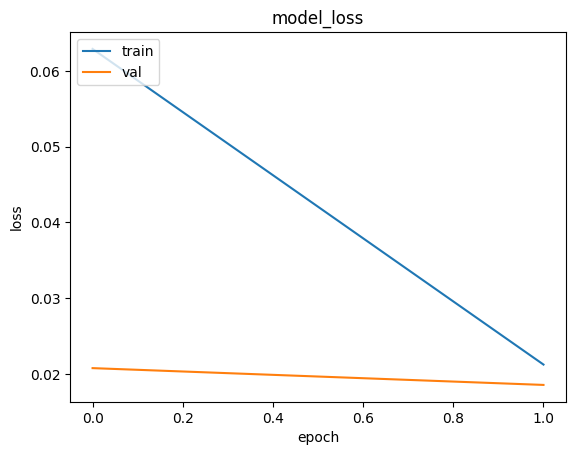

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
all_predictions = []
all_labels = []

In [25]:
for batch in tf_val_dataset:
   logits = model.predict(batch)["logits"]
   labels = batch["labels"].numpy()
   predictions = tf.argmax(logits, axis=-1).numpy()
   #print(labels)
   #print(predictions)
   for prediction, label in zip(predictions, labels):
      for predicted_idx, label_idx in zip(prediction, label):
         if label_idx == -100:
            continue
         all_predictions.append(id2label[predicted_idx])
         all_labels.append(id2label[label_idx])

1/1 [==============================] - 0s 366ms/step


In [26]:
seqeval.compute(predictions=[all_predictions], references=[all_labels])

{'LOCATION': {'precision': 0.9507042253521126,
  'recall': 0.9591474245115453,
  'f1': 0.9549071618037136,
  'number': 1126},
 'ORGANIZATION': {'precision': 0.9450171821305842,
  'recall': 0.9450171821305842,
  'f1': 0.9450171821305842,
  'number': 873},
 'PERSON': {'precision': 0.9614914425427873,
  'recall': 0.9812850904553961,
  'f1': 0.9712874343933312,
  'number': 1603},
 'overall_precision': 0.9541838134430727,
 'overall_recall': 0.9655746807329262,
 'overall_f1': 0.959845453291017,
 'overall_accuracy': 0.9947782258064516}

# Testing

In [27]:
inputs=tokenizer(["Coca Cola içtik Ahmet ile, Antalya sıcaktı çok."], truncation=True,return_tensors="tf")

In [28]:
print(inputs.tokens())
print(inputs.word_ids())
print(inputs['input_ids'])

['[CLS]', 'Co', '##ca', 'Cola', 'iç', '##tik', 'Ahmet', 'ile', ',', 'Antalya', 'sıcak', '##tı', 'çok', '.', '[SEP]']
[None, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 9, None]
tf.Tensor(
[[    2  7176  2145 29766  2032  2473  4542  2074    16  5084  3981  2071
   2140    18     3]], shape=(1, 15), dtype=int32)


In [29]:
logits = model(**inputs).logits
print(logits.shape)
print(tf.argmax(logits,axis=-1))

(1, 15, 7)
tf.Tensor([[0 3 4 4 0 0 5 0 0 1 0 0 0 0 0]], shape=(1, 15), dtype=int64)


In [30]:
out_str=""
current_index=0

In [31]:
for i in range(1,len(inputs.tokens())-1):
    if tf.argmax(logits,axis=-1)[0][i]!=0:
        out_str+=" "+str(inputs.tokens()[i])+"--->"+str(id2label[tf.argmax(logits,axis=-1).numpy()[0][i]])
    else:
        out_str+=" "+str(inputs.tokens()[i])

In [32]:
print(out_str.replace("##",""))

 Co--->B-ORGANIZATION ca--->I-ORGANIZATION Cola--->I-ORGANIZATION iç tik Ahmet--->B-PERSON ile , Antalya--->B-LOCATION sıcak tı çok .
